In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastai
from fastai.vision import *
import tensorflow
import keras
import os
import sys
import cv2
import random
import gc
from shutil import copyfile
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    Rotate,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

Using TensorFlow backend.


In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Load processed data from drive**

In [0]:
direc="./drive/My Drive/Datasets/unet"

In [3]:
# !cp /content/drive/My\ Drive/Datasets/unet/data.tar .
direc="./drive/My Drive/Datasets/unet"
!cp -r "$direc"/motorbike "$direc"/motorbike_mask "$direc"/motorbike_mask_raw .

cp: cannot stat './drive/My Drive/Datasets/unet/motorbike_mask_raw': No such file or directory


In [0]:
direc="./drive/My Drive/Datasets/unet"
!cp -r "$direc"/augmented.zip "$direc"/augmented_mask.zip .

In [0]:
!unzip augmented.zip 
!unzip augmented_mask.zip 

In [0]:
!cp augmented.zip "$direc"
!cp augmented_mask.zip "$direc"

#**Load dataset from drive**

In [0]:
!tar -xvf data.tar

In [0]:
%cd VOCdevkit/VOC2012/

/content/VOCdevkit/VOC2012


In [0]:
print(len(list(os.listdir('Annotations'))))
print(len(list(os.listdir('SegmentationClass'))))
print(len(list(os.listdir('SegmentationObject'))))
print(len(list(os.listdir('ImageSets'))))
print(len(list(os.listdir('JPEGImages'))))

17125
2913
2913
4
17125


In [0]:
!ls ImageSets/Segmentation

train.txt  trainval.txt  val.txt


In [0]:
print(os.listdir('SegmentationObject'))

['2007_006866.png', '2011_001748.png', '2008_005262.png', '2011_002200.png', '2011_002279.png', '2009_004504.png', '2007_007480.png', '2009_003323.png', '2011_001463.png', '2008_006553.png', '2008_001112.png', '2009_001802.png', '2011_002656.png', '2008_001249.png', '2007_003373.png', '2009_003804.png', '2007_001526.png', '2008_001106.png', '2011_003057.png', '2011_002114.png', '2011_001991.png', '2011_000969.png', '2011_003055.png', '2010_002310.png', '2007_003349.png', '2010_001933.png', '2007_004902.png', '2008_003779.png', '2007_007165.png', '2010_003293.png', '2008_007392.png', '2011_001782.png', '2008_008103.png', '2010_000978.png', '2008_007120.png', '2008_003379.png', '2008_004621.png', '2007_002281.png', '2010_005721.png', '2011_002589.png', '2011_001753.png', '2007_008897.png', '2009_002982.png', '2010_002527.png', '2008_000765.png', '2009_000412.png', '2008_005217.png', '2008_003210.png', '2008_003856.png', '2009_002844.png', '2010_001413.png', '2007_004722.png', '2011_00161

#**Separating inputs**

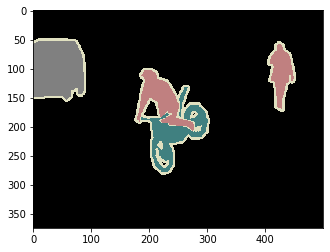

In [0]:
img = (plt.imread('SegmentationClass/2007_002643.png'))
plt.imshow(img)


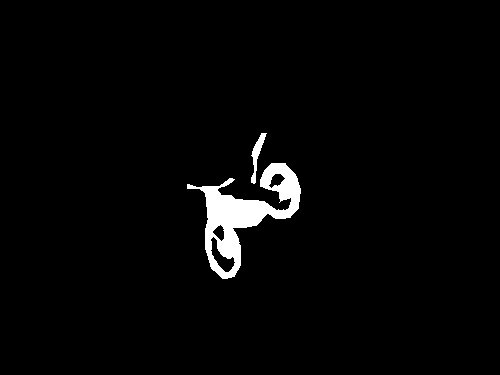

In [0]:
# color = np.uint8([[[64,128,128]]])
img = cv2.imread('SegmentationClass/2007_002643.png')
mask = cv2.inRange(img, (127,127,63), (129,129,65))
dst1 = cv2.bitwise_and(img, img, mask=mask)
dst1 = cv2.cvtColor(dst1, cv2.COLOR_BGR2GRAY)
thresh,dst1 = cv2.threshold(dst1, 1,255, cv2.THRESH_BINARY)
cv2_imshow(dst1)

In [0]:
dst1[225,225]

255

In [0]:
img_arr = np.array(img)
flat = np.reshape(img_arr,(img_arr.shape[0]*img_arr.shape[1],img_arr.shape[2]))
print(flat.shape)

(187500, 3)


In [0]:
np.where(flat==np.array([0,0,0]))

(array([     0,      0,      0, ..., 187499, 187499, 187499]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [0]:
flat_set = np.unique(flat)
print(flat_set)

[  0  64 128 192 224]


In [0]:
!ls

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [0]:
with open("ImageSets/Segmentation/train.txt") as f:
    train = f.read()
    train = train.split("\n")
    while('' in train):
        train.remove('')
with open("ImageSets/Segmentation/trainval.txt") as f:
    trainval = f.read()
    trainval = trainval.split("\n")
    while('' in trainval):
        trainval.remove('')
with open("ImageSets/Segmentation/val.txt") as f:
    val = f.read()
    val = val.split("\n")
    while('' in val):
        val.remove('')
# with open("ImageSets/Main/motorbike_train.txt") as f:
#     main = f.read()
#     main = main.split("\n")
#     while('' in main):
#         main.remove('')

In [0]:
train_set = set(train)
val_set = set(val)
trainval_set = set(trainval)
# main_set = set(main)

In [0]:
main_data = pd.read_csv("../../drive/My Drive/Datasets/unet/motorbike_train.txt",sep = " ", names=['one','two'],header=None)

In [0]:
main_set = set(list(main_data['one']))

In [0]:
print(len(train),len(val),len(trainval),main_data.shape,len(train_set)+len(val_set)+len(trainval_set))

1464 1449 2913 (5717, 2) 5826


In [0]:
intersect_set = set.intersection(main_set,trainval_set)
remove_set = main_set-intersect_set

In [0]:
main_data = main_data[main_data.one.isin(intersect_set)]
# main_data.drop(0,axis=0,drop=True)

In [0]:
md_one = main_data[main_data.two == 1]

In [0]:
md_one.head()

one  two
32   2008_000144    1
271  2008_001119    1
290  2008_001203    1
383  2008_001643    1
393  2008_001691    1

In [0]:
plt.imsave('../../fig.png',img)

In [0]:
!rm -rf ../../motorbike
!rm -rf ../../motorbike_mask
!rm -rf ../../motorbike_mask_raw

In [0]:
os.mkdir('../../motorbike')
os.mkdir('../../motorbike_mask')
os.mkdir('../../motorbike_mask_raw')
dest = '../../motorbike/'
dest_mask = '../../motorbike_mask/'
dest_mask_raw = '../../motorbike_mask_raw/'
for filename in list(md_one['one']):

    img = cv2.imread('JPEGImages/'+filename+'.jpg')
    cv2.imwrite(dest+filename+'.jpg',img)

    img_mask = cv2.imread('SegmentationClass/'+filename+'.png')
    cv2.imwrite(dest_mask_raw+filename+'.png',img_mask)
    mask = cv2.inRange(img_mask, (127,127,63), (129,129,65))
    dst1 = cv2.bitwise_and(img_mask, img_mask, mask=mask)
    dst1 = cv2.cvtColor(dst1, cv2.COLOR_BGR2GRAY)
    thresh,dst1 = cv2.threshold(dst1, 1,255, cv2.THRESH_BINARY)
    cv2.imwrite(dest_mask+filename+'.png',dst1)


In [0]:
%cp -r motorbike drive/My\ Drive/Datasets/unet/
%cp -r motorbike_mask drive/My\ Drive/Datasets/unet/
%cp -r motorbike_mask_raw drive/My\ Drive/Datasets/unet/

In [0]:
len(list(os.listdir('../../motorbike_mask')))

59

In [0]:
!zip -r ../../motorbike_mask.zip ../../motorbike_mask

#**Augmentation**

In [0]:
# %cd ../../

/content


In [0]:
src = 'motorbike/'
src_mask = 'motorbike_mask/'
src_mask_raw = 'motorbike_mask_raw/'

In [0]:
def resize_all():
    for image in list(os.listdir(src)):
        img = cv2.resize(cv2.imread(src+image),(512,512))
        cv2.imwrite(src+image,img)
        img = cv2.resize(cv2.imread(src_mask+image[:-3]+'png'),(512,512))
        cv2.imwrite(src_mask+image[:-3]+'png',img)
        img = cv2.resize(cv2.imread(src_mask_raw+image[:-3]+'png'),(512,512))
        cv2.imwrite(src_mask_raw+image[:-3]+'png',img)

In [0]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [0]:
image_list=list(os.listdir('motorbike/'))

In [0]:
image = cv2.imread(src+image_list[0])
mask = cv2.imread(src_mask+image_list[0][:-3]+'png',0)

In [0]:
print(image.shape, mask.shape)

(512, 512, 3) (512, 512)


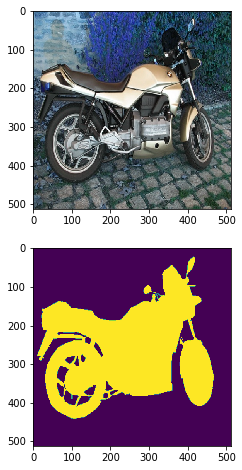

In [0]:
original_height, original_width = image.shape[:2]
visualize(image, mask)

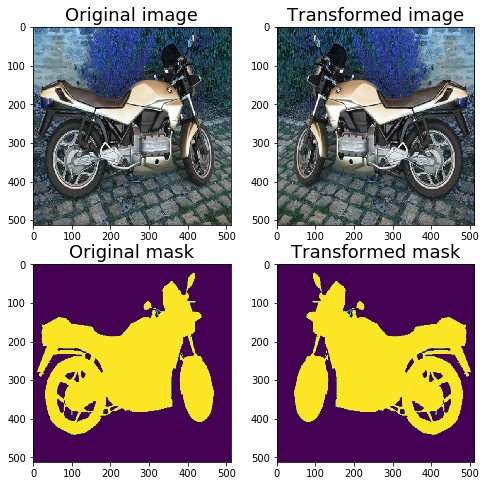

In [0]:
aug = HorizontalFlip(p=1)
augmented = aug(image=image, mask=mask)
image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']
visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

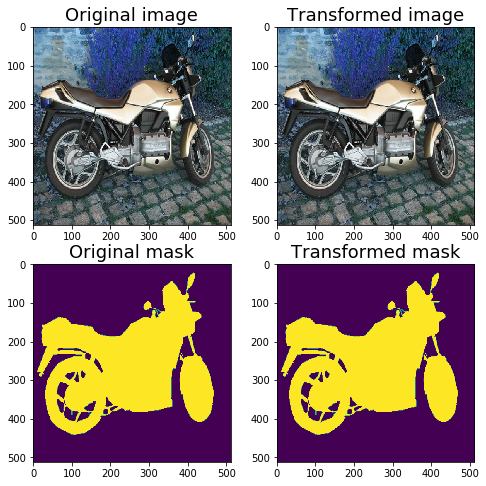

In [0]:
aug = RandomRotate90(p=1)
augmented = aug(image=image, mask=mask)
image_rot90 = augmented['image']
mask_rot90 = augmented['mask']
visualize(image_rot90, mask_rot90, original_image=image, original_mask=mask)

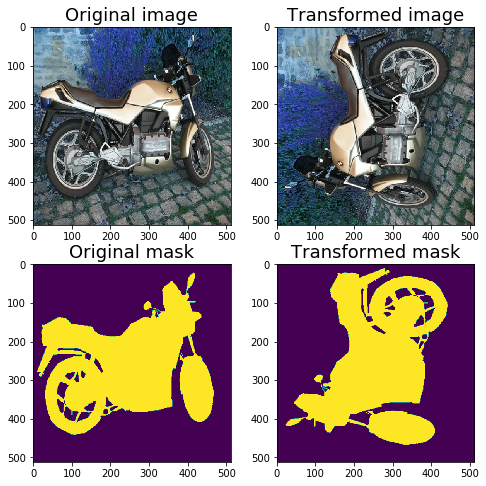

In [0]:
aug = Transpose(p=1)
augmented = aug(image=image, mask=mask)
image_transposed = augmented['image']
mask_transposed = augmented['mask']
visualize(image_transposed, mask_transposed, original_image=image, original_mask=mask)

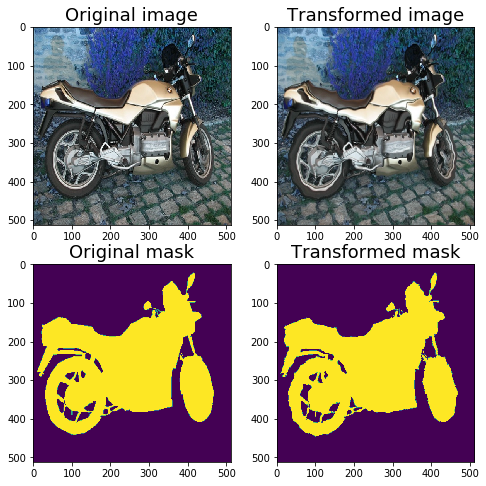

In [0]:
aug = ElasticTransform(p=1, alpha=random.randint(55,65), sigma=random.randint(110,130) * 0.05, alpha_affine=120 * 0.03)
augmented = aug(image=image, mask=mask)
image_elastic = augmented['image']
mask_elastic = augmented['mask']
visualize(image_elastic, mask_elastic, original_image=image, original_mask=mask)

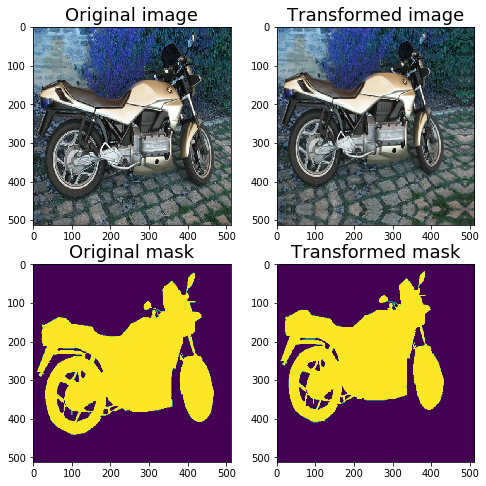

In [0]:
aug = GridDistortion(p=1)
augmented = aug(image=image, mask=mask)
image_grid = augmented['image']
mask_grid = augmented['mask']
visualize(image_grid, mask_grid, original_image=image, original_mask=mask)


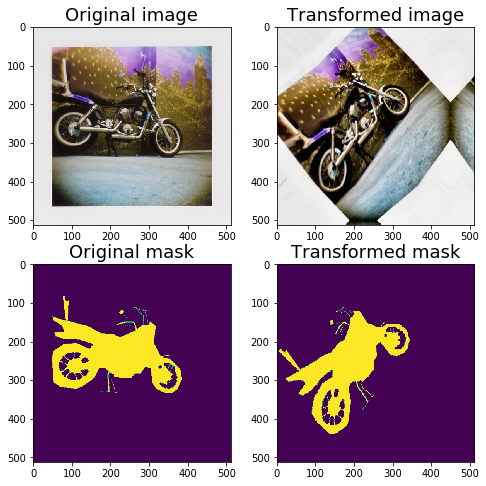

In [0]:
aug = Compose([
    OneOf([RandomSizedCrop(min_max_height=(505, 505), height=original_height, width=original_width, p=0.5),
          PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)], p=1),         
    Rotate(p=0.8, limit=45, interpolation=cv2.INTER_AREA, border_mode=cv2.BORDER_REPLICATE),
    OneOf([
        ElasticTransform(p=0.8, alpha=random.randint(55,70), sigma=random.randint(120,130) * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=1),
        OpticalDistortion(p=0.8, distort_limit=0.01, shift_limit=0.2, interpolation=cv2.INTER_AREA)                  
        ], p=0.8),
    CLAHE(p=0.9),
    RandomBrightnessContrast(p=0.9),    
    RandomGamma(p=0.9)])

augmented = aug(image=image, mask=mask)

image_heavy = augmented['image']
mask_heavy = augmented['mask']

visualize(image_heavy, mask_heavy, original_image=image, original_mask=mask)

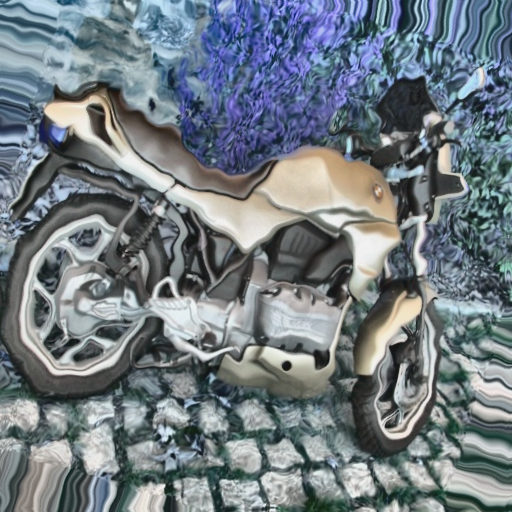

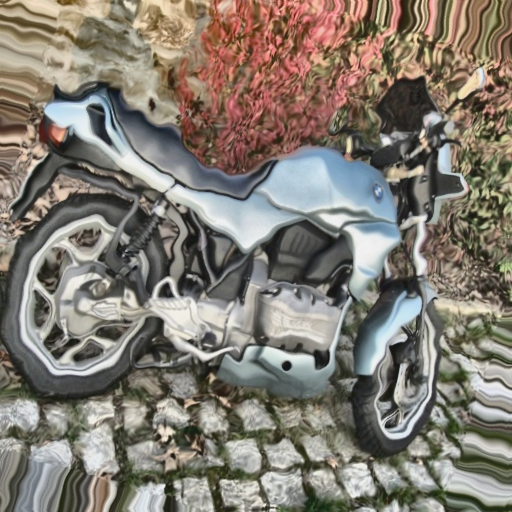

In [0]:
cv2_imshow(cv2.cvtColor(image_heavy, cv2.COLOR_BGR2RGB))
cv2_imshow(image_heavy)

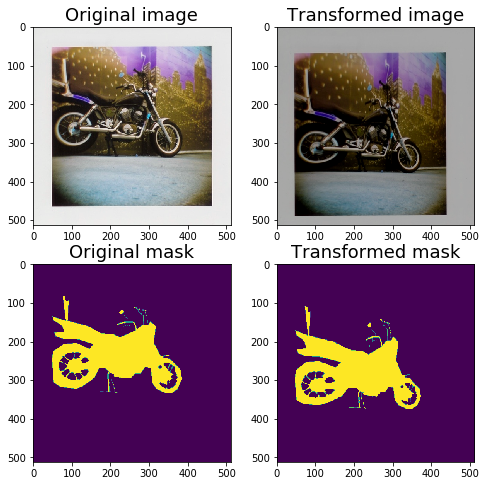

In [0]:
augmented = aug(image=image, mask=mask)
image_heavy = augmented['image']
mask_heavy = augmented['mask']
visualize(image_heavy, mask_heavy, original_image=image, original_mask=mask)

In [0]:
# !rm -rf augmented
# !rm -rf augmented_mask

In [0]:
!mkdir augmented
!mkdir augmented_mask

In [0]:
 for j in range(10):
    for i in range(len(list(os.listdir(src)))):
            image = cv2.imread(src+image_list[i])
            mask = cv2.imread(src_mask+image_list[i][:-3]+'png',0)
            augmented = aug(image=image, mask=mask)
            image_heavy = augmented['image']
            mask_heavy = augmented['mask']
            cv2.imwrite('augmented/{}_{}_{}_c.png'.format(image_list[i][:-4],i,j),cv2.cvtColor(image_heavy, cv2.COLOR_BGR2RGB))
            cv2.imwrite('augmented_mask/{}_{}_{}_c.png'.format(image_list[i][:-4],i,j), mask_heavy)
            cv2.imwrite('augmented/{}_{}_{}.png'.format(image_list[i][:-4],i,j), image_heavy)
            cv2.imwrite('augmented_mask/{}_{}_{}.png'.format(image_list[i][:-4],i,j), mask_heavy)


In [0]:
len(list(os.listdir('augmented_mask')))

1239

In [0]:
%cp -a motorbike/. augmented/
%cp -a motorbike_mask/. augmented_mask/

In [0]:
%cp -r augmented drive/My\ Drive/Datasets/unet/
%cp -r augmented_mask drive/My\ Drive/Datasets/unet/

#**Load data into array**

In [0]:
X = []
y = []
for i in list(os.listdir('augmented')):
    X.append(cv2.imread('augmented/'+i)/255)
    y.append(cv2.imread('augmented_mask/'+i[:-3]+'png',0)/255)

X = np.array(X).astype('float32')
y = np.array(y).astype('int8')
y = np.reshape(y,(y.shape[0],y.shape[1],y.shape[2],1))

In [0]:
# y = np.reshape(y,(y.shape[0],y.shape[1],y.shape[2],1))

In [8]:
y.shape

(59, 512, 512, 1)

In [0]:
gc.collect()

36

#**Vanilla Unet using keras**

In [0]:
image_size = 512
epochs = 5
batch_size = 2


##**Custom loss functions (Dice coefficient)**

In [0]:
def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
  denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
  return 1 - (numerator + 1) / (denominator + 1)


In [12]:
model = keras.models.load_model('drive/My Drive/Datasets/unet/unet_conv_0.9751065289817833.h5')
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_batchnorm2.h5",monitor='val_loss', 
                                   mode = 'min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode = 'min',factor=0.2, patience=5, min_lr=0.00001, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1)





##**Overfit on small batch to test convergence**

In [15]:
history = model.fit(X[:59], y[:59],
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Train on 47 samples, validate on 12 samples
Epoch 1/20
47/47 [==============================] - 14s 290ms/step - loss: 0.0572 - acc: 0.9767 - val_loss: 0.0658 - val_acc: 0.9750

Epoch 00001: val_loss improved from inf to 0.06580, saving model to ./unet_batchnorm.h5
Epoch 2/20
47/47 [==============================] - 7s 147ms/step - loss: 0.0585 - acc: 0.9760 - val_loss: 0.0558 - val_acc: 0.9783

Epoch 00002: val_loss improved from 0.06580 to 0.05581, saving model to ./unet_batchnorm.h5
Epoch 3/20
47/47 [==============================] - 7s 146ms/step - loss: 0.0491 - acc: 0.9796 - val_loss: 0.0594 - val_acc: 0.9780

Epoch 00003: val_loss did not improve from 0.05581
Epoch 4/20
47/47 [==============================] - 7s 146ms/step - loss: 0.0448 - acc: 0.9816 - val_loss: 0.0571 - val_acc: 0.9791

Epoch 00004: val_loss did not improve from 0.05581
Epoch 5/20
47/47 [==============================] - 7s 146ms/step - loss: 0.0440 - acc: 0.9819 - val_loss: 0.0529 - val_acc: 0.9798

Epoch 00

##**Training on full training set**

In [0]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c1 = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c2 = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c1)
    c3 = keras.layers.BatchNormalization()(c2)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c3)
    return c2, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c1 = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c2 = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c1)
    c3 = keras.layers.BatchNormalization()(c2)
    return c2

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [0]:
def UNet():
    f = [64,128,256,512,1024]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #512 -> 256
    c2, p2 = down_block(p1, f[1]) #256 -> 128
    c3, p3 = down_block(p2, f[2]) #128 -> 64
    c4, p4 = down_block(p3, f[3]) #64 -> 32
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #32 -> 64
    u2 = up_block(u1, c3, f[2]) #64 -> 128
    u3 = up_block(u2, c2, f[1]) #128 -> 256
    u4 = up_block(u3, c1, f[0]) #256 -> 512
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [49]:
model = UNet()
model.compile(optimizer=optimizers.Adam(lr=0.00001), loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 64) 256         conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
model = keras.models.load_model('drive/My Drive/Datasets/unet/unet_conv_4.h5')

In [128]:
history = model.fit(X, y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Train on 991 samples, validate on 248 samples
Epoch 1/5
991/991 [==============================] - 148s 149ms/step - loss: 0.0079 - acc: 0.9966 - val_loss: 0.0574 - val_acc: 0.9873

Epoch 00001: val_loss did not improve from 0.05107
Epoch 2/5
991/991 [==============================] - 146s 147ms/step - loss: 0.0079 - acc: 0.9966 - val_loss: 0.0702 - val_acc: 0.9857

Epoch 00002: val_loss did not improve from 0.05107
Epoch 3/5
991/991 [==============================] - 146s 147ms/step - loss: 0.0081 - acc: 0.9965 - val_loss: 0.0583 - val_acc: 0.9870

Epoch 00003: val_loss did not improve from 0.05107
Epoch 4/5
991/991 [==============================] - 146s 147ms/step - loss: 0.0080 - acc: 0.9965 - val_loss: 0.0619 - val_acc: 0.9867

Epoch 00004: val_loss did not improve from 0.05107
Epoch 5/5
991/991 [==============================] - 146s 147ms/step - loss: 0.0080 - acc: 0.9965 - val_loss: 0.0600 - val_acc: 0.9871

Epoch 00005: val_loss did not improve from 0.05107


In [0]:
model.save('drive/My Drive/Datasets/unet/unet_conv_{}_3.h5'.format(history.history['acc'][-1]))

In [0]:
xx = model.predict(np.array([X[2]]))
# xx = xx.astype('int8')

In [131]:
np.max(np.unique(xx))

1.0

In [0]:
img = np.reshape(xx[0],(512,512,))*255

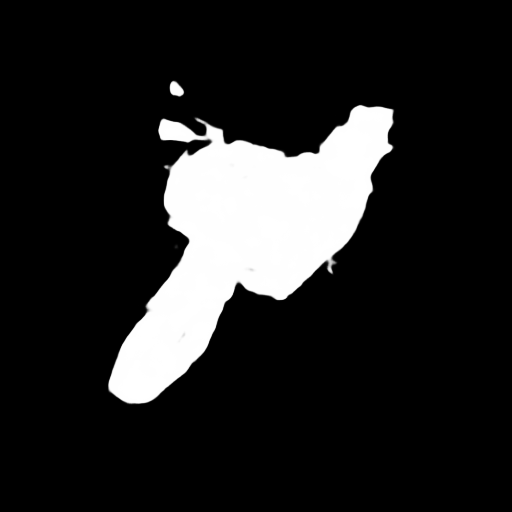

In [133]:
cv2_imshow((np.reshape(xx[0],(512,512,))*255))

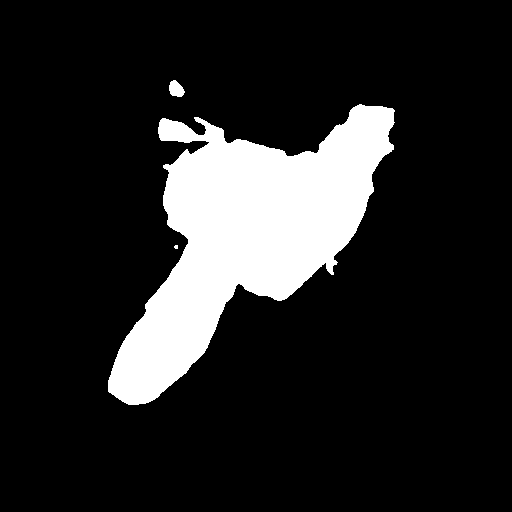

In [134]:
cv2_imshow(cv2.threshold((np.reshape(xx[0],(512,512,))*255), 10,255,cv2.THRESH_BINARY)[1])

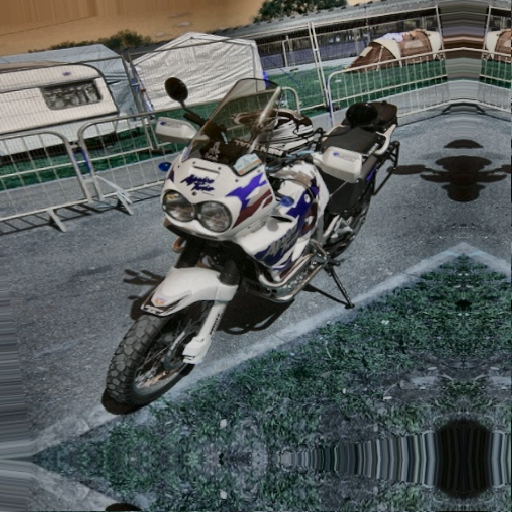

In [135]:
cv2_imshow(X[2]*255)

##**plot overlay**

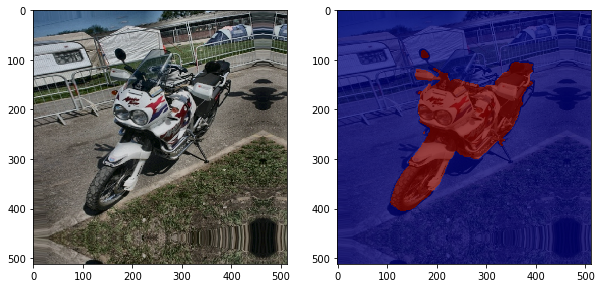

In [136]:
plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
plt.imshow(X[2], interpolation='none')
plt.subplot(1,2,2)
plt.imshow(X[2], 'gray', interpolation='none')
plt.imshow(cv2.threshold((np.reshape(xx[0],(512,512,))*255), 5,255,cv2.THRESH_BINARY)[1], 'jet', interpolation='none', alpha=0.7)
plt.show()

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = epochs


plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

#**Test images**

In [0]:
import xml.etree.ElementTree as ET
def parse_xml_2(directory, tag_content=True, subdir=True):
	xml_files = []
	if subdir:
		for xml_root, dirs, files in os.walk(directory):
			for file in files:
				if file.endswith(".xml"):
					 xml_files.append((xml_root, file))
	else:
		for file in list(os.listdir(directory)):
			if file.endswith(".xml"):
				xml_files.append((directory,file))

	dict_main = {}

	for xml_root,xml_file in xml_files:
		dict_sub = {}
		fl = str(xml_root+'/'+xml_file)
		tree = ET.ElementTree().parse(source = fl)
		x = tree.iter()
		for _ in x:
			dict_sub[_.tag] = {'text':_.text, 'attrib':_.attrib}
		dict_main[xml_file] = dict_sub


	return dict_main

In [0]:
x = parse_xml_2('./drive/My Drive/Datasets/unet/Annotations')

In [0]:
s = set()
for _ in x:
    s.add(x[_]['name']['text'])

In [109]:
s

{'diningtable', 'person'}